In [1]:
import requests as r
import pandas as pd
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup as bs
%matplotlib inline
from collections import Counter
import numpy as np
import re
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import jieba
from nltk import word_tokenize
import json
import seaborn as sns

In [194]:
forum = pd.read_pickle('./forum260.pkl')

In [196]:
forum.shape

(6734, 2)

In [197]:
stopwords = [line.replace("\n",'') for line in open('stopwords.txt','r').readlines()]

In [198]:
def cutting(text):
    text_c = jieba.cut(text)
    return text_c

In [199]:
def stopwords(w):
    if w not in stop_tokens:
        return w

In [200]:
def regular(w):
    line = re.findall('[\u4e00-\u9fa5]+', w)
    if len(line) > 0:
        return line

In [201]:
syn_dict = {}
with open("syn.txt","r") as f :
    for line in f:
        for word in line.strip("\n").split("\t")[1:]:
            syn_dict[word] = line.strip("\n").split("\t")[0]

In [202]:
def syn(w):
    if w in syn_dict.keys():
        w=syn_dict[w]
        return w
    else:
        return w

In [203]:
#version3 cut first, not what i want
def trimming(data):
    filtered_w = []
    words = cutting(data) 
    for word in words:
        word = regular(word)
        if word is not None:
            stop_w = stopwords(word[0])
            if stop_w is not None:
                syn_w = syn(stop_w)
                filtered_w.append(syn_w)
    return " ".join(filtered_w)

In [204]:
forum["tokens"] = forum['content'].map(trimming)

In [205]:
forum.shape

(6734, 3)

In [245]:
forum['reply'] = pd.to_numeric(forum['reply'])

In [266]:
len(forum[(forum['reply'] >=4 )])/len(forum)

0.31630531630531633

In [322]:
def categorizing(reply):
    if reply >=4: return 'Issue'
    else: return 'Non-Issue'    

In [323]:
forum["Creply"] = forum['reply'].map(categorizing)
forum["Creply"].head()

0    Non-Issue
1        Issue
2    Non-Issue
3    Non-Issue
4    Non-Issue
Name: Creply, dtype: object

In [325]:
forum.drop(forum.columns[:3], axis=1).head()

,target,Creply
0,0,Non-Issue
1,1,Issue
2,0,Non-Issue
3,0,Non-Issue
4,0,Non-Issue


In [326]:
forum['target'] = (forum['Creply'] == 'Issue').astype(int)
forum.drop('Creply', axis=1 , inplace= True)

In [327]:
forum['target'][6:10]

6    0
7    0
8    1
9    0
Name: target, dtype: int32

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [329]:
target_name= 'target'
X = forum['tokens']
y = forum[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [330]:
vect = TfidfVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm  = vect.transform(X_test)

In [331]:
def CMatrix(CM, labels = ['Non-Issue','Issue']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUTH'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [332]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB

In [333]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

In [334]:
# nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_test = nb.predict(X_test_dtm)

In [335]:
precision = precision_score(y_true=y_test,y_pred=y_pred_test)
accruacy  = accuracy_score(y_true=y_test, y_pred=y_pred_test)

In [336]:
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)

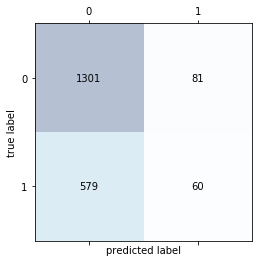

In [337]:
# y_pred = model.predict(X_test)
# confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print(confmat)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(CM, cmap=plt.cm.Blues, alpha=0.3)
for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
        ax.text(x=j, y=i, s=CM[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [338]:
print("Accuracy:  {:0.2f}%".format(100*accruacy))  # 整體正確率
print("Precision: {:0.2f}%".format(100*precision)) # 精確值: TP/TP+FP
CMatrix(CM)

Accuracy:  67.34%
Precision: 42.55%


PREDICTION,Non-Issue,Issue,Total
TRUTH,,,
Non-Issue,1301,81,1382
Issue,579,60,639
Total,1880,141,2021


In [339]:
def issue_filter(text):
    """Accept a string containing a text message and classifies it as Issue or Non-Issue"""
    text_message = trimming(text)
    prediction = nb.predict(vect.transform([text_message]))[0]
    print(text)
    if prediction:
        return "Issue"
    else:
        return "Non-Issue"

In [1748]:
import joblib
joblib.dump(nb,'./save/pkl_objects/nb_IssNon.pkl')

['./save/pkl_objects/nb_IssNon.pkl']